# Vine Copulas

## General Introduction to Vine Copulas

Vine Copulas are ....


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('C:/Users/jcl202/Documents/Phd/Data_exploration/Copulas/')
import vinecopulas3 as func

The data used as an example is the Abalone dataset from the UCI database (http://archive.ics.uci.edu/ml/datasets/Abalone) and has also been showcased in a chapter on Vine copula based modelling by Czado and Nagler (2021).  Abalones are marine snails whose shells have a spiral structure. The data set contains measurements on diameter, length, and several types of weight (whole, shucked, viscera and shell) of abalones, a type of marine snail. For this example, only data on the female snails are included and are loaded in below.

In [106]:
datapath = r'C:\Users\jcl202\Documents\Phd\Data_exploration\Copulas\sample_data.csv' #path to data
df = pd.read_csv(datapath) #load data
df.head() #show data columns and first rows 

,whole,shuck,vis,shell,diameter,length
0,0.6770,0.2565,0.1415,0.21,0.420,0.530
1,0.7775,0.2370,0.1415,0.33,0.415,0.530
2,0.7680,0.2940,0.1495,0.26,0.425,0.545
3,0.8945,0.3145,0.1510,0.32,0.440,0.550
4,0.6065,0.1940,0.1475,0.21,0.380,0.525


As explained in (link to introduction to bivariate copulas), in order to fit copulas to the data it needs to be transformed into uniformly distributed marginals. In this example we will do so by determening the best fit distribution of each variable in the dataset and applying the cumulative distribution function of that distribution to the variable. 

In [107]:
x = np.array(df) #turn dataframe into an array
#u =  func.pseudodata(x)
u = x.copy() #make a copy of data which will be transformed 
for i in range(len(df.columns)):
    namedist =  'dist'+ str(i) #define a name for the distribution of each variable
    locals()[namedist] =  func.best_fit_distribution(x[:,i]) #fit the best fit distribution to each variable
    u[:,i] = locals()[namedist][0].cdf(u[:,i] , *locals()[namedist][1]) #compute the CDF of the variable using the best fit distribution

plot the data

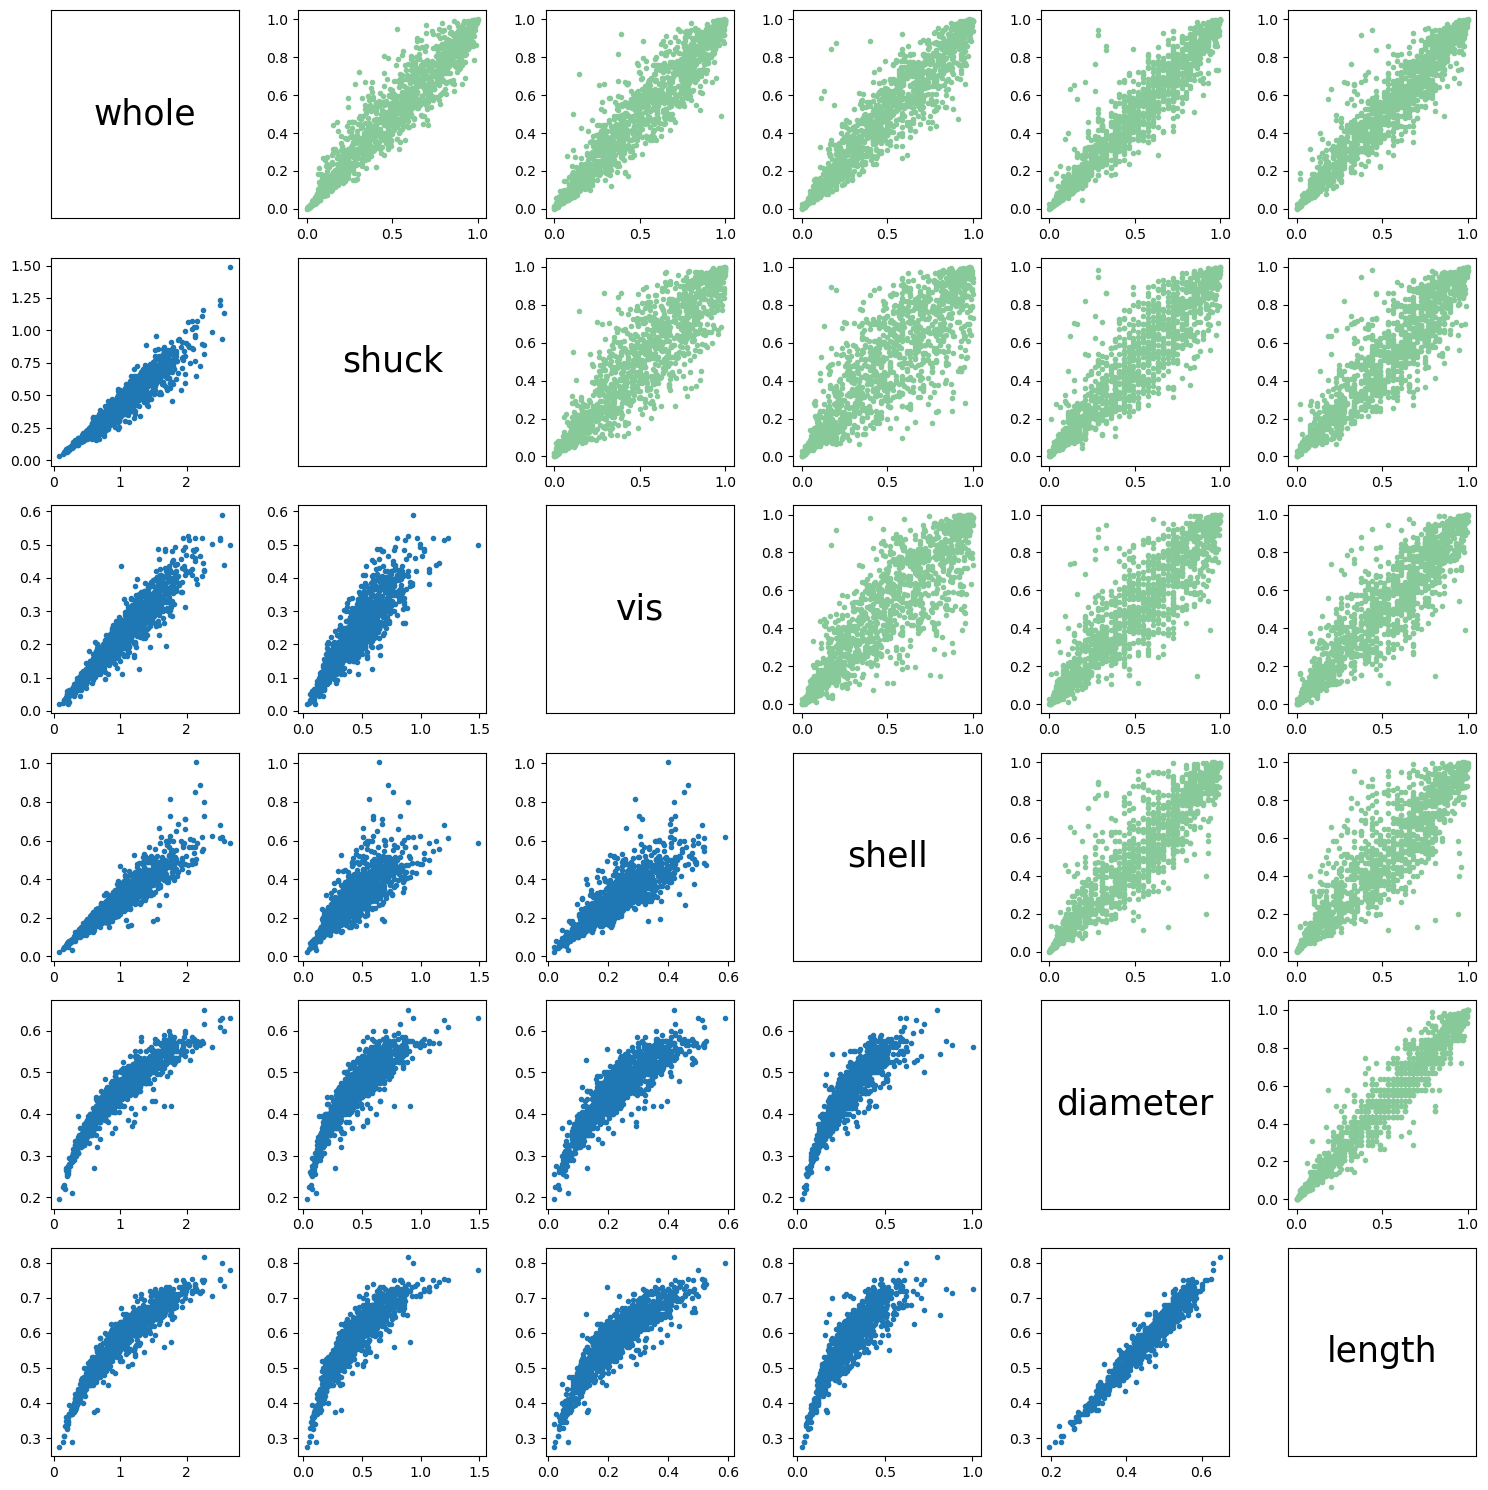

In [108]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            ax.scatter(x[:,j], x[:,i], marker='.')
        elif i < j:  # Upper diagonal
            ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=25, color='black')
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.show()

the available copula types and their ID

| ID | Copula              |
|----|---------------------|
| 1  | Gaussian            |
| 2  | Gumbel              |
| 3  | Gumbel 90 degrees   |
| 4  | Gumbel 180 degrees  |
| 5  | Gumbel 270 degrees  |
| 6  | Clayton             |
| 7  |  Clayton 90 degrees |
| 8  | Clayton 180 degrees |
| 9  | Clayton 270 degrees |
| 10 | Frank               |
| 11 | Joe                 |
| 12 | Joe 90 degrees      |
| 13 | Joe 180 degrees     |
| 14 | Joe 270 degrees     |
| 15 | Student             |

In [109]:
cops = list(range(1,16)) # fit vine copula according to these copulas (all of them)
m, p, c = func.vinecop(u, cops)

** Tree:  0
[1, 0] Gumbel180  ---> parameters =  5.646871761963549
[3, 0] Gumbel180  ---> parameters =  4.8913632248159225
[2, 0] Gumbel180  ---> parameters =  4.94887842985758
[0, 5] Gumbel180  ---> parameters =  5.3262714583069855
[4, 5] Gumbel180  ---> parameters =  6.401980791090651
** Tree:  1
[1, 3, '|', 0] Student  ---> parameters =  [-0.6498728754754225, 5.6968709940825075]
[3, 2, '|', 0] Gumbel90  ---> parameters =  1.1535165229694186
[2, 5, '|', 0] Gumbel0  ---> parameters =  1.0604224244293796
[0, 4, '|', 5] Student  ---> parameters =  [0.4024356978634496, 6.06647458208048]
** Tree:  2
[1, 2, '|', 3, 0] Student  ---> parameters =  [-0.42128958408740463, 5.7168844291694665]
[3, 5, '|', 2, 0] Gumbel180  ---> parameters =  1.0384336442487299
[2, 4, '|', 5, 0] Frank  ---> parameters =  -0.4797326787799648
** Tree:  3
[1, 5, '|', 2, 3, 0] Student  ---> parameters =  [0.20298151877339482, 16.05712143348811]
[3, 4, '|', 5, 2, 0] Frank  ---> parameters =  1.4912826677780728
** Tree:

In [118]:
n = len(u)
ui = func.samplecop(m, p,  c, n) #sample vine copula


In [119]:
xi = ui.copy()
for i in range(len(df.columns)):
    namedist =  'dist'+ str(i)
    xi[:,i] = locals()[namedist][0].ppf(ui[:,i] , *locals()[namedist][1])


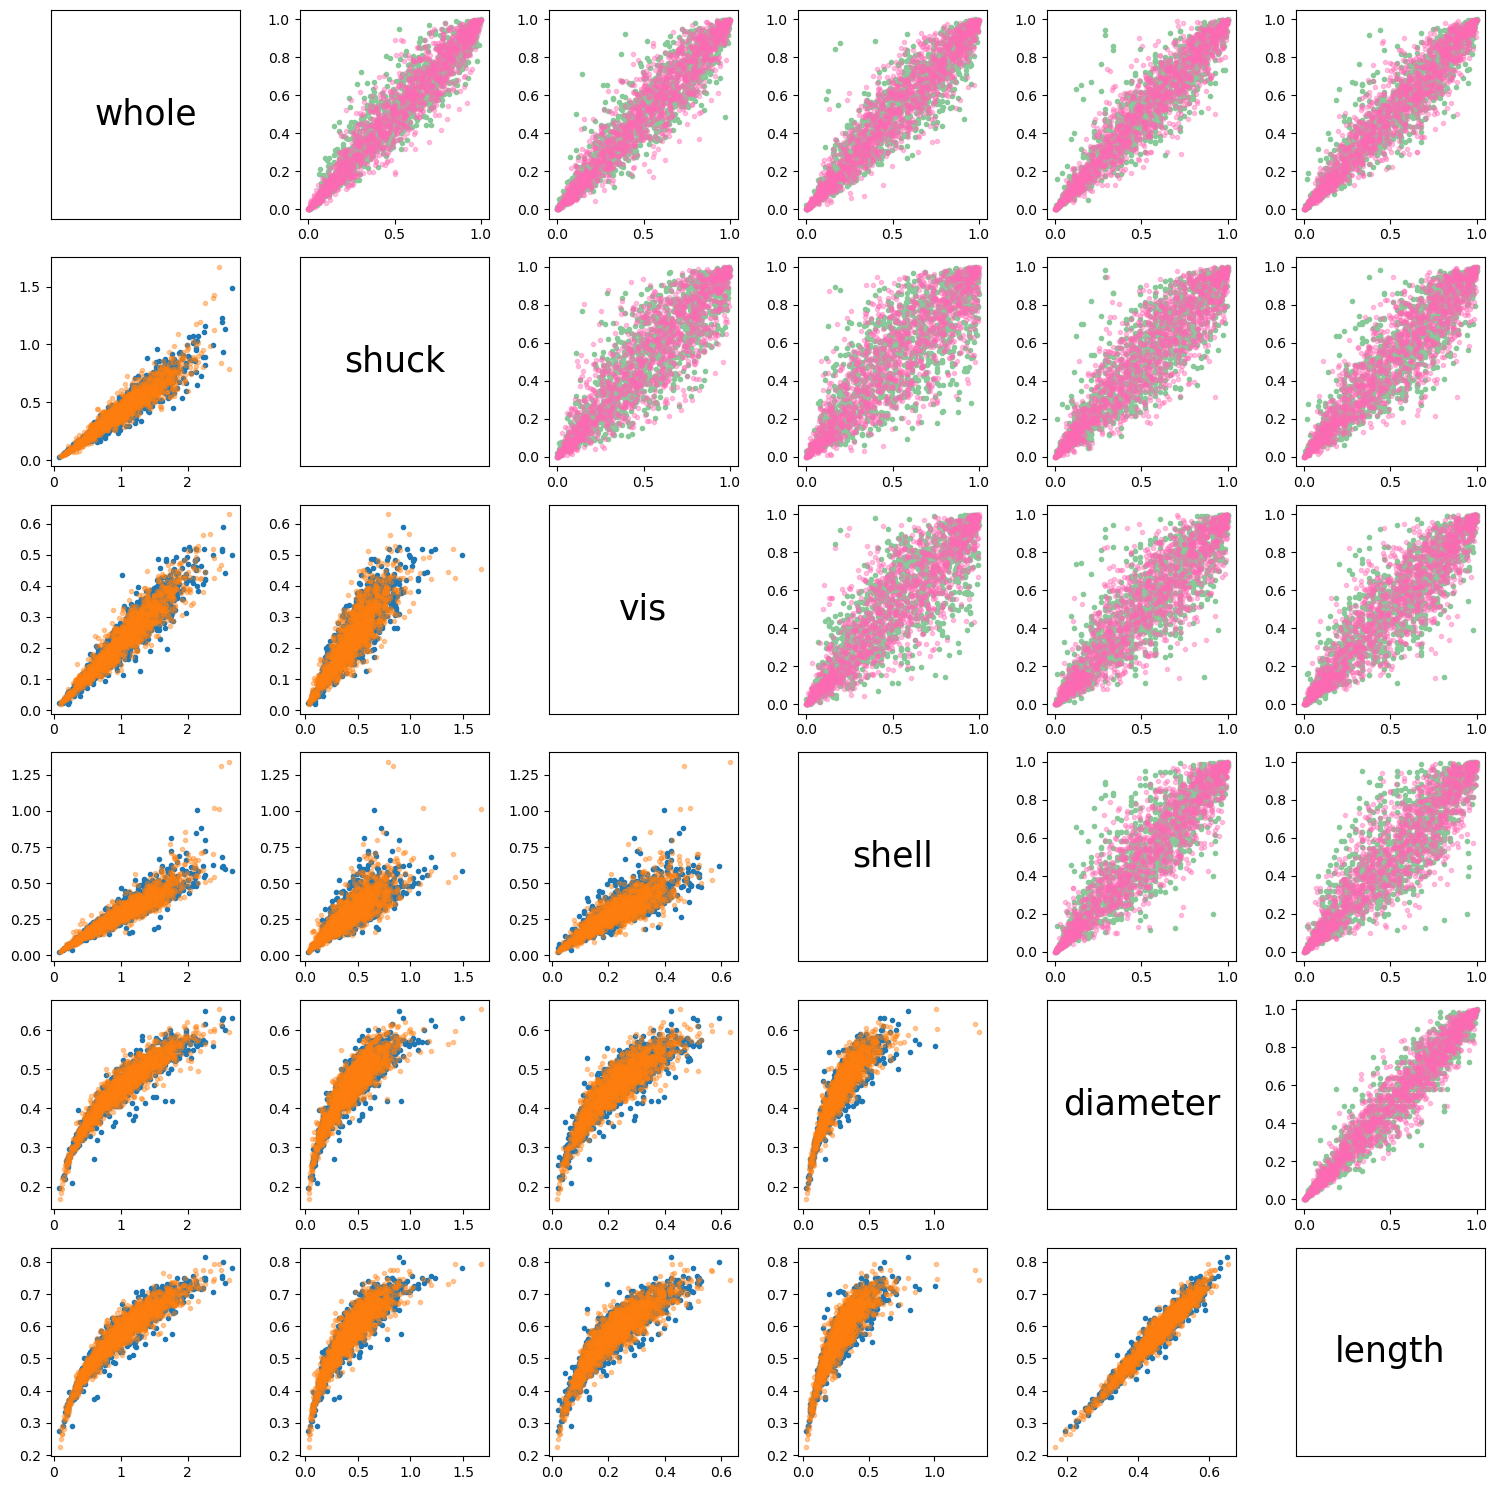

In [120]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15)) # plot random data
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            ax.scatter(x[:,j], x[:,i], marker='.')
            ax.scatter(xi[:,j], xi[:,i], marker='.', alpha = 0.4)
        elif i < j:  # Upper diagonal
            ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999')
            ax.scatter(ui[:,j], ui[:,i], marker='.', alpha = 0.4, color = 'hotpink')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=25, color='black')
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.show()

In [121]:
print('Sampling order of this vinecopula = ', np.diag(m[::-1])[::-1], 'so we can conditionally sample variable 1,', df.columns[1], 'based on the other variables')
Uc = np.array([0.67980855,0.63717041,0.56013869,0.63902887, 0.50213038]) # samples, ordered according to sampling order, more details to follow in explanation
n = 150
uci = func.vincopconditionalsample(m, p,c, n, Uc) #generate conditional samples
xci = uci.copy()
for i in range(len(df.columns)):
    namedist =  'dist'+ str(i)
    xci[:,i] = locals()[namedist][0].ppf(uci[:,i] , *locals()[namedist][1])


Sampling order of this vinecopula =  [5. 4. 0. 2. 3. 1.] so we can conditionally sample variable 1, shuck based on the other variables


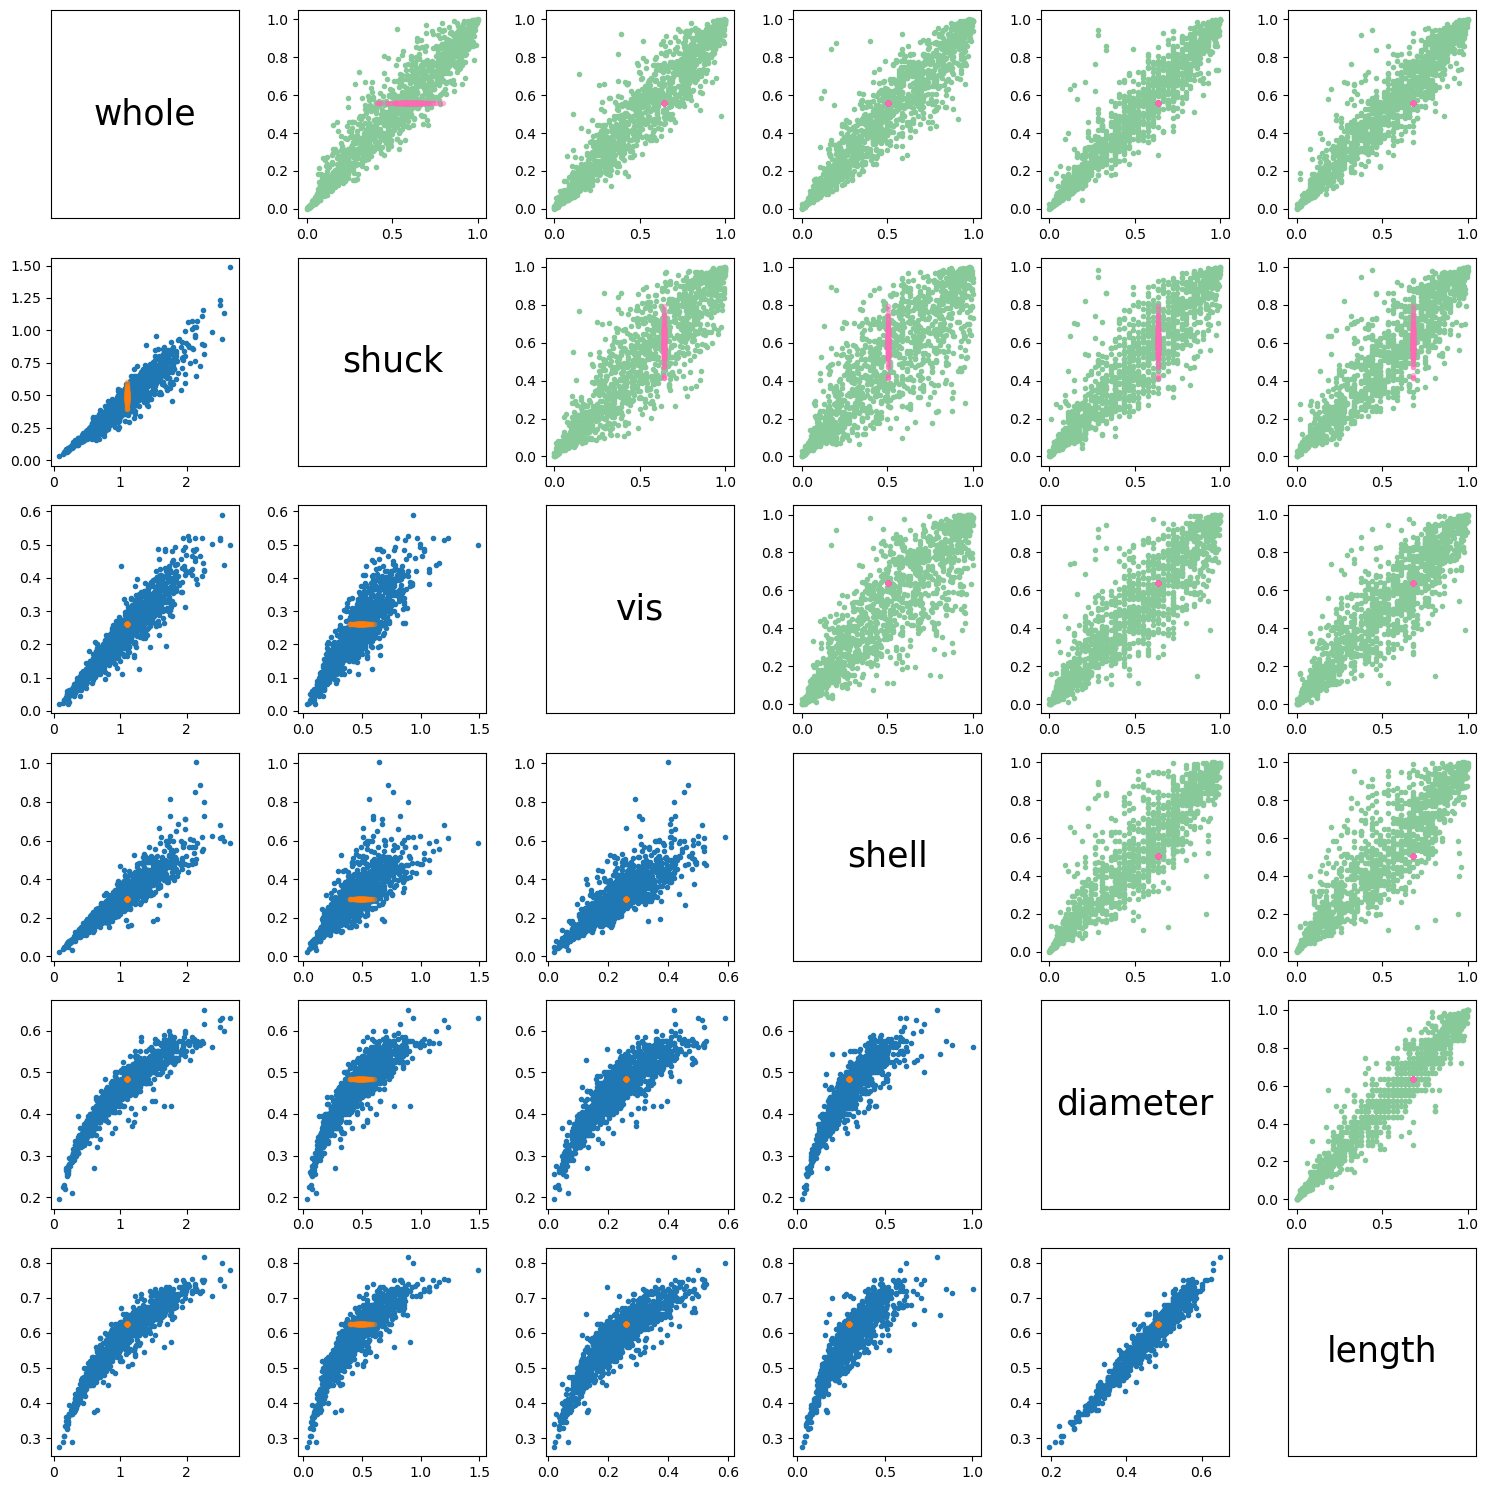

In [122]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            ax.scatter(x[:,j], x[:,i], marker='.')
            ax.scatter(xci[:,j], xci[:,i], marker='.', alpha = 0.4)
        elif i < j:  # Upper diagonal
            ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999')
            ax.scatter(uci[:,j], uci[:,i], marker='.', alpha = 0.4, color = 'hotpink')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=25, color='black')
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.show()


In [123]:
#fit copula based on a variable of interest
vint = 5 #variable of interest
mc, pc, cc = func.copconditional(u, vint, cops)

** Tree:  0
[1, 0] Gumbel180  ---> parameters =  5.646871761963549
[2, 0] Gumbel180  ---> parameters =  4.94887842985758
[3, 0] Gumbel180  ---> parameters =  4.8913632248159225
[0, 4] Gumbel180  ---> parameters =  5.281990259061084
[4, 5] Gumbel180  ---> parameters =  6.401980791090651
** Tree:  1
[1, 3, '|', 0] Student  ---> parameters =  [0.4189230515869861, 11.356780600746388]
[2, 3, '|', 0] Student  ---> parameters =  [-0.6498728754754225, 5.6968709940825075]
[3, 4, '|', 0] Joe180  ---> parameters =  1.029735514004635
[0, 5, '|', 4] Student  ---> parameters =  [-0.1454327139860745, 8.392116213586727]
** Tree:  2
[1, 4, '|', 3, 0] Student  ---> parameters =  [0.5829847977265585, 6.5391091787262505]
[2, 4, '|', 3, 0] Student  ---> parameters =  [0.21677524525582026, 7.714520937095748]
[3, 5, '|', 4, 0] Student  ---> parameters =  [0.03364903920693816, 7.852240793359418]
** Tree:  3
[1, 2, '|', 4, 3, 0] Student  ---> parameters =  [0.08609867222937424, 9.263250566127828]
[2, 5, '|', 4

## Sampling orders
there are $2^{n-1}$ implied sampling orders for any regular
vine on $n$ variables (Cooke et al. 2015)

In [124]:
sos = func.samplingorder(mc, cc, pc) #provide all the different sampling orders that are possible
sos

[[5.0, 4.0, 0.0, 3.0, 2.0, 1.0],
 [4.0, 0.0, 3.0, 2.0, 1.0, 5.0],
 [4.0, 0.0, 3.0, 2.0, 5.0, 1.0],
 [4.0, 0.0, 3.0, 1.0, 2.0, 5.0],
 [4.0, 0.0, 3.0, 5.0, 2.0, 1.0],
 [3.0, 0.0, 2.0, 4.0, 1.0, 5.0],
 [3.0, 0.0, 2.0, 4.0, 5.0, 1.0],
 [3.0, 0.0, 1.0, 4.0, 2.0, 5.0],
 [4.0, 0.0, 5.0, 3.0, 2.0, 1.0],
 [3.0, 0.0, 4.0, 2.0, 1.0, 5.0],
 [3.0, 0.0, 4.0, 2.0, 5.0, 1.0],
 [3.0, 0.0, 4.0, 1.0, 2.0, 5.0],
 [3.0, 0.0, 4.0, 5.0, 2.0, 1.0],
 [2.0, 0.0, 3.0, 4.0, 1.0, 5.0],
 [2.0, 0.0, 3.0, 4.0, 5.0, 1.0],
 [1.0, 0.0, 3.0, 4.0, 2.0, 5.0],
 [4.0, 5.0, 0.0, 3.0, 2.0, 1.0],
 [0.0, 4.0, 3.0, 2.0, 1.0, 5.0],
 [0.0, 4.0, 3.0, 2.0, 5.0, 1.0],
 [0.0, 4.0, 3.0, 1.0, 2.0, 5.0],
 [0.0, 4.0, 3.0, 5.0, 2.0, 1.0],
 [0.0, 3.0, 2.0, 4.0, 1.0, 5.0],
 [0.0, 3.0, 2.0, 4.0, 5.0, 1.0],
 [0.0, 3.0, 1.0, 4.0, 2.0, 5.0],
 [0.0, 4.0, 5.0, 3.0, 2.0, 1.0],
 [0.0, 3.0, 4.0, 2.0, 1.0, 5.0],
 [0.0, 3.0, 4.0, 2.0, 5.0, 1.0],
 [0.0, 3.0, 4.0, 1.0, 2.0, 5.0],
 [0.0, 3.0, 4.0, 5.0, 2.0, 1.0],
 [0.0, 2.0, 3.0, 4.0, 1.0, 5.0],
 [0.0, 2.0

In [125]:
so = sos[1]
mci, pci, cci = func.samplingmatrix(mc,cc,pc,so)
so

[4.0, 0.0, 3.0, 2.0, 1.0, 5.0]

In [126]:
Uc = np.array([ 0.436558,0.37705822,0.34795295, 0.55813935, 0.36220572]) # ordered according to sampling order
n = 150
uci = func.vincopconditionalsample(mci, pci,cci, n, Uc)
xci = uci.copy()
for i in range(len(df.columns)):
    namedist =  'dist'+ str(i)
    xci[:,i] = locals()[namedist][0].ppf(uci[:,i] , *locals()[namedist][1])
    

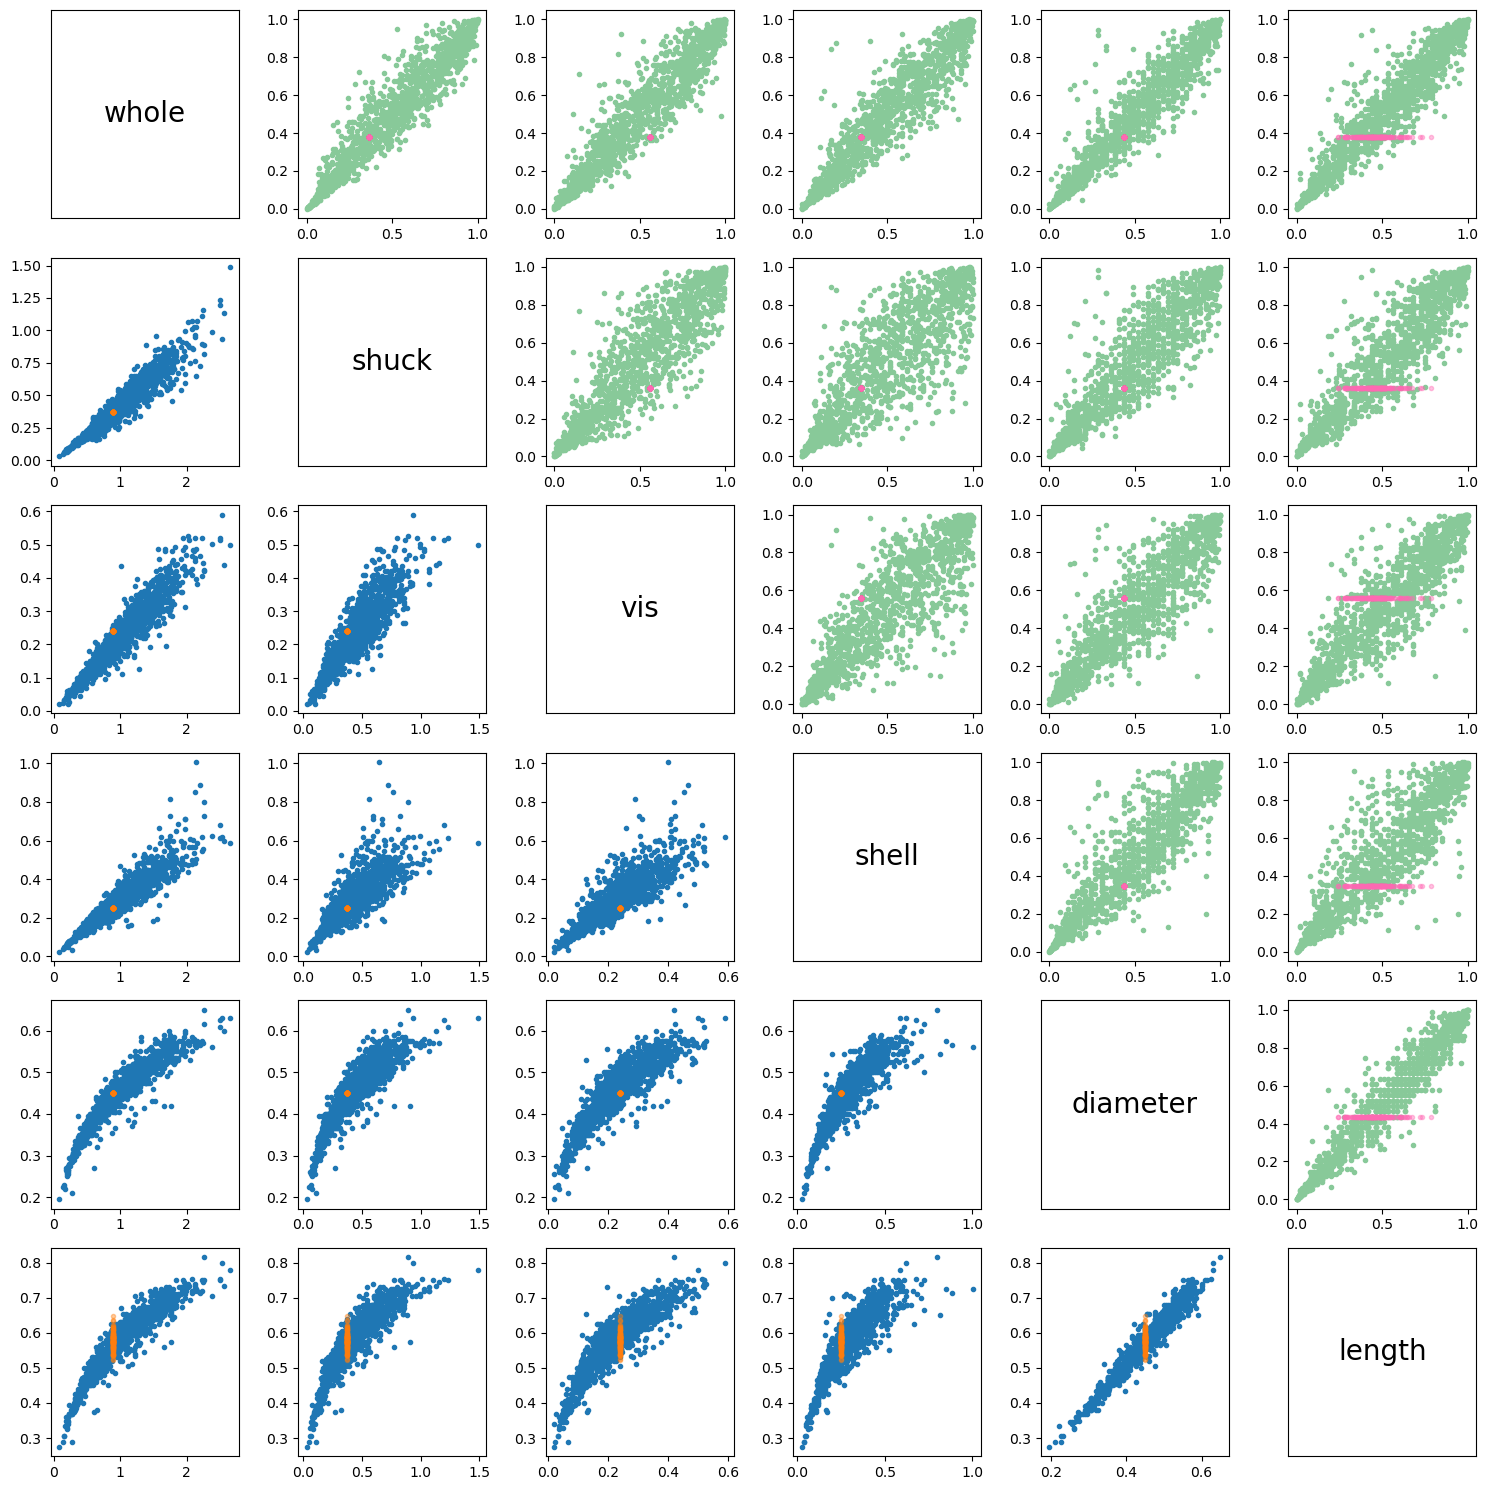

In [127]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            ax.scatter(x[:,j], x[:,i], marker='.')
            ax.scatter(xci[:,j], xci[:,i], marker='.', alpha = 0.4)
        elif i < j:  # Upper diagonal
            ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999')
            ax.scatter(uci[:,j], uci[:,i], marker='.', alpha = 0.4, color = 'hotpink')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=20, color='black')
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.show()

In [128]:
#sample based on just one conditional variable (which has to be the first variable in the sampling order)
Uc = np.array([ 0.9]) # ordered according to sampling order
n = 150
uci = func.vincopconditionalsample(mci, pci,cci, n, Uc)
xci = uci.copy()
for i in range(len(df.columns)):
    namedist =  'dist'+ str(i)
    xci[:,i] = locals()[namedist][0].ppf(uci[:,i] , *locals()[namedist][1])

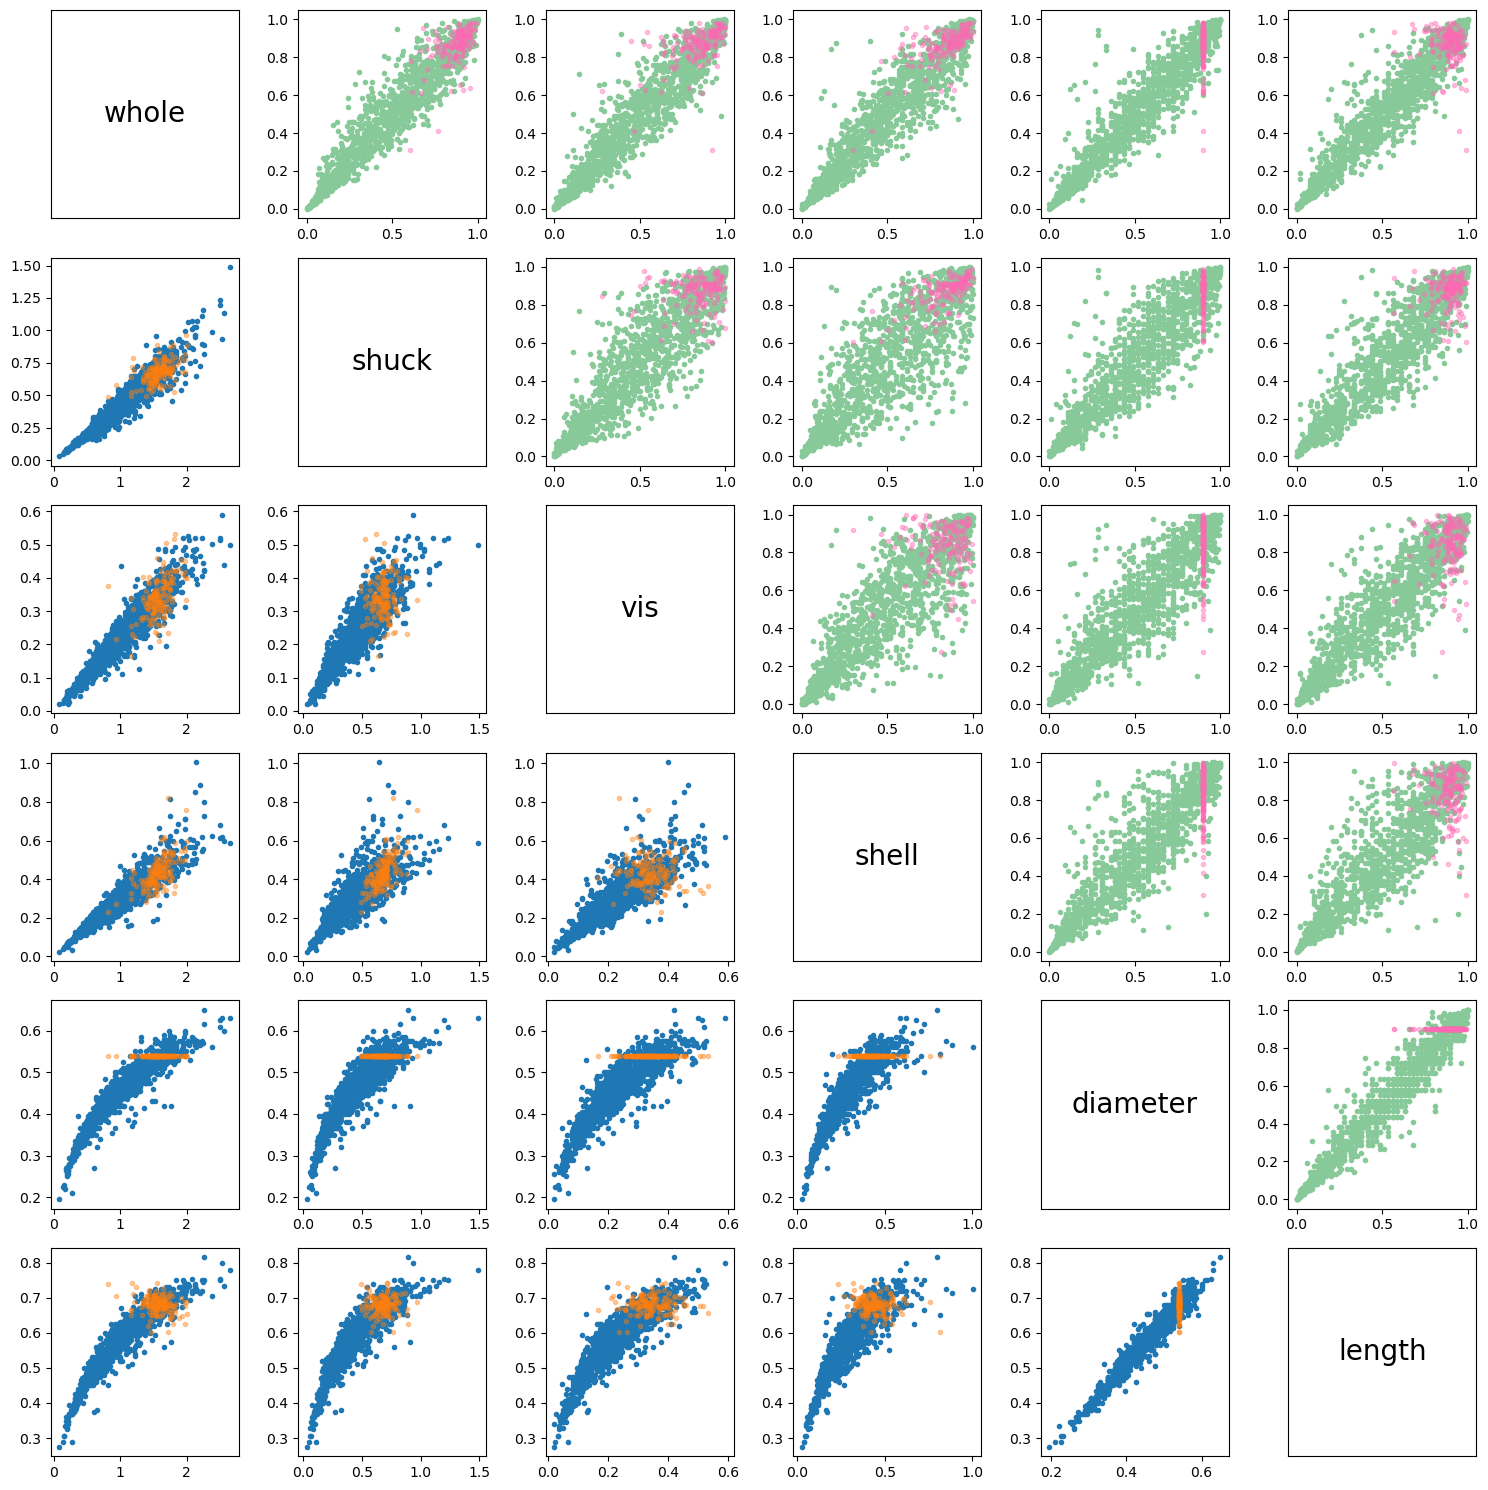

In [129]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            ax.scatter(x[:,j], x[:,i], marker='.')
            ax.scatter(xci[:,j], xci[:,i], marker='.', alpha = 0.4)
        elif i < j:  # Upper diagonal
            ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999')
            ax.scatter(uci[:,j], uci[:,i], marker='.', alpha = 0.4, color = 'hotpink')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=20, color='black')
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.show()